In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import copy

In [2]:
import sys
import datagnome as dgnom
#from importlib import reload
#reload(dgnom)

# Workflow

1. Data import
1. Unsupervised learning
    1. Data Preparations
        1. X & y
    1. Select no of principal components (if PCA)
    1. Select number of clusters
    1. Train model
1. Supervised learning
    1. Data Preparations
        1. X & y
        1. Train test split
    1. Preliminary feature selection
    1. Train & eval different models
        1. Choose best model(s)
        1. Final feature selection (manual & wrapper)
    1. Hyperparameter tuning for best model(s)
        1. Proceed with best model
    1. Predictions on test data, final test against benchmark
1. Save model

# Data import

In [3]:
path = "mushrooms_clean.csv"
df = pd.read_csv(path)

# Supervised learning

In [4]:
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LogisticRegression, Ridge

## Data preparations

In [5]:
target = "class"

X = df.drop(target,axis=1)
y = df[target]

In [7]:
# Alternative 1 for determining manually which category that is assigned as True
#y.unique()
#dct = {"e":0,"p":1}
#y = y.map(dct)

In [6]:
X_train,X_TEST,y_train,y_TEST = train_test_split(X,y,test_size=0.2,random_state=42)
df2 = X_train.join(y_train)

## Preliminary feature selection
Filter methods

C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  warnings.warn(


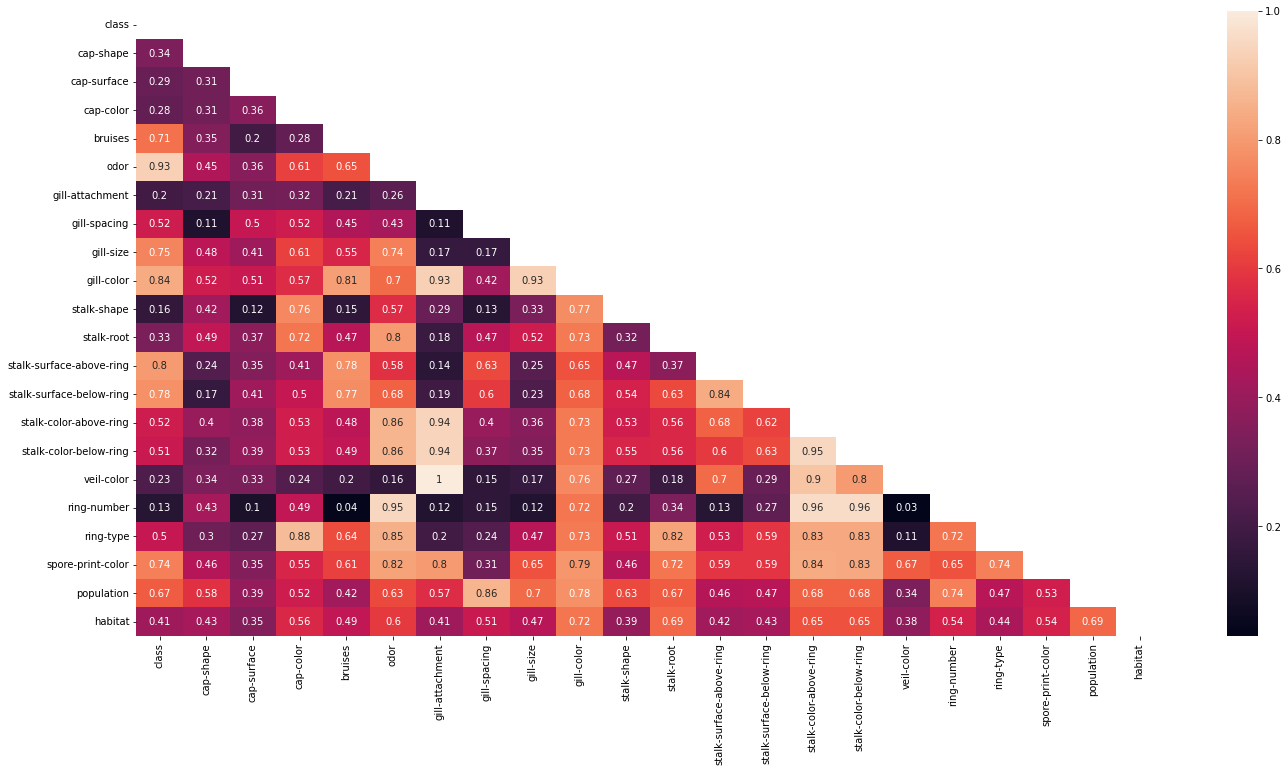

In [18]:
# Correlation matrix, numerical and non-numerical columns
target = "class"
target = False
dgnom.df_corrphik(df,col=target)

C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  warnings.warn(


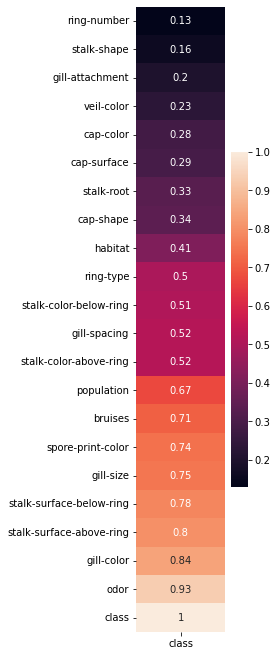

In [26]:
# Correlation matrix, numerical and non-numerical columns
target = "class"
dgnom.df_corrphik(df,col=target)

In [79]:
target = "class"
corr = df.phik_matrix().round(2)
bracol = corr.loc[corr[target]>0.5][target].drop(target).index.to_list()
bracol

C:\Users\ander\anaconda3\envs\kursenv\lib\site-packages\phik\data_quality.py:82: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  warnings.warn(


['bruises',
 'odor',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'spore-print-color',
 'population']

## Classification model

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import make_column_transformer

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import f1_score,precision_score,recall_score, accuracy_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import make_scorer
from functools import partial

from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
#!pip install mlxtend
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.math import num_combinations

### Workflow

1. Choice of Performance Metric
    - Accuracy = True predictions / All predictions
    - Precision = TP / (TP + FP) → Hit Ratio when making a positive prediction
    - Recall / Sensitivity = TP / (TP + FN) → Ability to capture all members of
positive group
    - Specificity = TN / (TN + FP) → Ability to capture all members of negative
group
    - F1-score = 2* (Recall + Precision) / (Recall + Precision) → Performance metric
especially useful for imbalanced classes
    - AUC / ROC curve = Used to evaluate performance at various threshold
settings
    - Custom metric
1. Choice of scalers:
    - StandardScaler: Industry standard
    - RobustScaler: For data with outliers
    - MinMaxScaler: Good choice for features that are not standard distributet and do not contain outliers
    - https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02
1. Feature selection
1. Model selection
    - https://scikit-learn.org/stable/supervised_learning.html
1. Hyperparameter tuning
1. Refit best model on all training data
1. Evaluate model performance on training data
1. Evaluate model performance on test data
1. Refit best model on all data
1. Update datafram

### Prepare pipeline

In [68]:
# Custom metric
def hesf(y_true, y_pred):
    tp = 51000*len([t for t,p in zip(y_true, y_pred) if (t==p and p=="e")])
    tn = 50000*len([t for t,p in zip(y_true, y_pred) if (t==p and p=="p")])
    fp = 0*len([t for t,p in zip(y_true, y_pred) if (t!=p and p=="e")])
    fn = 50000*len([t for t,p in zip(y_true, y_pred) if (t!=p and p=="p")])
    p = 51000*len([t for t in y_true if t==1])
    n = 50000*len([t for t in y_true if t==0])
    
    return (tp+tn+fp+fn)/(p+n)
score = make_scorer(hesf, greater_is_better=True)

In [112]:
def pipe_egen(models,num_trans,cat_trans,col,Xin,yin,scor,p_param=False,cv=5,sfs=False,sfsdir="forward"):
    """Create pipeline
    
    Parameters
    ---------
    classifiers:  List of models to evaluate  
    num_trans:    Transformer for numerical columns in preprocessing pipeline
    cat_trans:    Transformer for non-numerical columns in preprocessing pipeline 
    col:          Cols to be included
    p_grid:       List of Dicts - one for each model - with hyperparameters values to evaluate  
    Xin:          X
    yin:          y
    scor:         Scoring function, if classification: {accuracy | f1 | precision | recall | roc_auc | ...}
                                    if regression: {r2 | explained_variance | ...}
    cv:           Number of folds used for cross validation, default 5
    sfs:          Use SequentialFeatureSelector from skleanr for feature selection {True | False}, default False
    sfsdir:       Direction of SequentialFeatureSelector {"forward" | "backward"}, default "forward"
    """
    trainedm = []
    hyparam = p_param if p_param else [{} for i in range(len(classifiers))]
    
    num_features = Xin.loc[:,col].select_dtypes("number").columns.to_list()
    cat_features = Xin.loc[:,col].select_dtypes(exclude="number").columns.to_list()
    preprop = make_column_transformer(
        (num_trans,num_features),
        (cat_trans,cat_features))
    
    for m,pg in zip(models,hyparam):
        if sfs:
            mc = copy.deepcopy(m)
            sfsm = SequentialFeatureSelector(mc,n_features_to_select=None,direction=sfsdir,scoring=scor,cv=cv)
            pipe = make_pipeline(preprop,sfsm,m)
        else:
            pipe = make_pipeline(preprop,m)
        
        grid = GridSearchCV(pipe,param_grid=pg,cv=cv,scoring=scor)
        grid.fit(Xin,yin)
        trainedm.append(grid)
        print(f"Score for {m} is: {grid.best_score_} (with hyperparams: {grid.best_params_})") 
    return trainedm

In [113]:
def fs_sfs_mlxl(Xin,yin,models,num_trans,cat_trans,col,fstype="sfs",scor="accuracy",cv=5,
                xaxfull=False,k_feat="best",forw=True,flt=False,max_feat=2,vb=0):

    num_features = Xin.loc[:,col].select_dtypes("number").columns.to_list()
    cat_features = Xin.loc[:,col].select_dtypes(exclude="number").columns.to_list()
    preprop = make_column_transformer(
        (num_trans,num_features),
        (cat_trans,cat_features))
    
    for m in models:
        if fstype == "efs":
            xaxfull = True
            fsize = (20,14)
            tl = "Exhaustive Feature Selector"
            fs = EFS(m, min_features = 1, max_features = max_feat, scoring=scor, print_progress = True, cv = cv)
        else:
            fsize = (6,4)
            tl = "Sequential Forward Selection (w. StdErr)"
            fs = SFS(m, k_features = k_feat, forward = forw, floating = flt, scoring = scor, cv = cv,
                    verbose = vb)
        
        pipe = make_pipeline(preprop,fs)
        pipe.fit(Xin, yin)
        
        # Plot results
        # ALT: plot_sfs from mlxtend
        plot_mlxl_gs(pipe[1],tl,xaxfull=xaxfull,fsize=fsize)
        if cat_features:
            namnut = pipe[0].transformers_[0][2] + list(pipe[0].transformers_[1][1][1].get_feature_names_out(cat_features))
        else:
            namnut = pipe[0].transformers_[0][2]
        
        if fstype == "efs":
            print(f"Best features for {m}: {[namnut[i] for i in pipe[1].best_idx_]}")
        else:
            print(f"Best features for {m}: {[namnut[i] for i in pipe[1].k_feature_idx_]}")
        print("---------")
        
    print(f"Name and number for all features:")
    print({i:namnut[i] for i in range(len(namnut))})
    
def plot_mlxl_gs(sfs,model_name,xaxfull=True,fsize=(6,4)):
    metric_dict = sfs.get_metric_dict()
    k_feat = sorted(metric_dict.keys())
    avg = [metric_dict[k]['avg_score'] for k in k_feat]
    upper, lower = [], []
    
    for k in k_feat:
        upper.append(metric_dict[k]['avg_score'] + metric_dict[k]['std_dev'])
        lower.append(metric_dict[k]['avg_score'] - metric_dict[k]['std_dev'])

    fig = plt.figure(figsize=fsize)
    plt.fill_between(k_feat,upper,lower,alpha=0.15,color='blue',lw=1)
    plt.plot(k_feat, avg, color='blue', marker='o')
    plt.title(f"{model_name}".capitalize(),fontsize = 12)
    plt.ylabel("Performance +/- standard Deviation",fontsize = 10)
    plt.xlabel("Number of Features",fontsize = 10)
    plt.grid()
    
    if xaxfull:
        plt.xticks(k_feat, [str(metric_dict[k]['feature_idx']) for k in k_feat], rotation=90)
    else:
        plt.xticks(k_feat, [str(len(metric_dict[k]['feature_idx'])) for k in k_feat])
    plt.show()

In [75]:
# Scoring metric classification
scormetrc = "accuracy" # As string
scormetrc = make_scorer(partial(precision_score, pos_label="p")) # As make_scorer, use if there is need to define the positive (True) label

scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = MinMaxScaler()

num_trans = make_pipeline(SimpleImputer(strategy="median"),scaler)
cat_trans = make_pipeline(SimpleImputer(strategy = "constant",fill_value="missing"),
                         OneHotEncoder(drop="if_binary"))

classifiers = [LogisticRegression(max_iter=1000),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               SVC(),
               KNeighborsClassifier(),
               GaussianNB()]

# Dafault hyperparameter values can be found in the description of each model:
# https://scikit-learn.org/stable/supervised_learning.html
p_grid = [{"logisticregression__C":[0.1,1,10,100]},
          {"decisiontreeclassifier__max_depth":[None,20,50],
           "decisiontreeclassifier__min_samples_leaf":[1,2,4]},
          {"randomforestclassifier__n_estimators":[100,200,75],
           "randomforestclassifier__max_depth":[None,20,50],
           "randomforestclassifier__min_samples_leaf":[1,2,4]},
          {"svc__C": [0.1,1,10,100,1000],
           "svc__gamma": [1,0.5,0.1,0.05,0.01]},
          {"kneighborsclassifier__n_neighbors": [3,5,11,15,19],
           "kneighborsclassifier__metric": ["euclidean","manhattan"]},
          {}
         ]

### Model selection

__Summary of result__
- Continue work with LogisticRegression and RandomForestClassifier
- Feature selection by SFS proved cumbersome. Final selection was instead done by manually during the hyperparameter tuning.

In [158]:
# Check best model, without automatic feature selection
cols = X_train.columns.to_list()
#cols = bracol
#cols = ['bruises','odor','gill-spacing','gill-size','gill-color','stalk-surface-above-ring']

sm = scormetrc
sm = "accuracy"
#descm1
trmod = pipe_egen(classifiers[0:5],num_trans,cat_trans,cols,X_train,y_train,scor=sm,p_param=False,cv=5,sfs=False,sfsdir="forward")

Score for LogisticRegression(max_iter=1000) is: 0.9998460354118552 (with hyperparams: {})
Score for DecisionTreeClassifier() is: 1.0 (with hyperparams: {})
Score for RandomForestClassifier() is: 1.0 (with hyperparams: {})
Score for SVC() is: 1.0 (with hyperparams: {})
Score for KNeighborsClassifier() is: 1.0 (with hyperparams: {})


### Feature selection

#### By model coefficients

In [139]:
def getutnames(m):
    nc = m[0].transformers_[0][2]
    cc = m[0].transformers_[1][2]
    
    if cc:
        return nc + list(m[0].transformers_[1][1][1].get_feature_names_out(cc))
    else:
        return nc

In [179]:
def logreg_coef(mm):
    coef = [abs(i) for i in mm[1].coef_[0]]
    names = getutnames(mm)
    ncd = dict(zip(names,coef))
    return sorted(ncd.items(), key=lambda item: item[1],reverse=True)

In [180]:
mod = trmod[0].best_estimator_
logreg_coef(mod)

[('odor_n', 4.080442910954095),
 ('spore-print-color_r', 3.638695177707922),
 ('gill-size_n', 3.2088836037139847),
 ('odor_a', 2.8769075020695714),
 ('odor_l', 2.8717892520067894),
 ('odor_c', 2.7273439123519663),
 ('odor_f', 2.5729706272551147),
 ('odor_p', 2.417155824198496),
 ('gill-spacing_w', 2.1879422327845566),
 ('stalk-root_b', 2.158569622762442),
 ('gill-color_b', 1.9860532771472532),
 ('stalk-surface-above-ring_k', 1.6699255489619411),
 ('spore-print-color_n', 1.621138938182939),
 ('spore-print-color_u', 1.497491494779382),
 ('spore-print-color_k', 1.4573635224180754),
 ('stalk-surface-below-ring_y', 1.4508366244194109),
 ('population_c', 1.3548535111612423),
 ('ring-type_f', 1.3385227750249071),
 ('habitat_w', 1.228801402467856),
 ('stalk-surface-below-ring_f', 1.2075750829311782),
 ('stalk-shape_t', 1.1790199323351316),
 ('population_y', 1.1457432474321858),
 ('spore-print-color_h', 1.0545569674291706),
 ('stalk-root_c', 1.0530346496729475),
 ('stalk-root_r', 1.047239550629

In [182]:
bracol

['bruises',
 'odor',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'spore-print-color',
 'population']

In [190]:
bracol = ['bruises','odor','gill-spacing','gill-size','gill-color','stalk-surface-above-ring',
          'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring',
          'spore-print-color','population','stalk-root']

#### By SFS

In [ ]:
# Feature selection by SFS
# Notice that OneHotEncoder will create additional columns from catagorical features. If large number of 
# categorical features are included the analysis migth take a very long time.
cols = X_train.columns.to_list()
cols = bracol
cols = ['bruises','odor','gill-spacing','gill-size','gill-color','stalk-surface-above-ring',
        'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','spore-print-color',
        'population','stalk-root']

#sm = scormetrc
sm = "accuracy"

#X_train_num,dctu = dgnom.df_catnum(X_train,"bruises")
#X_train_num = dgnom.df_allcatnum(X_train)
clas = [classifiers[0],classifiers[2]]

# Perform feature selection with SequentialFeatureSelector from mlxtend
fs_sfs_mlxl(X_train,y_train,clas,num_trans,cat_trans,cols,fstype="sfs",scor=sm,cv=5,xaxfull=False,k_feat="best",forw=True,flt=False,max_feat=3)

#### Manual selection of features

In [229]:
# Check best model, without automatic feature selection
#cols = X_train.columns.to_list()
#cols = bracol
cols = ['bruises','odor','gill-spacing','gill-size','gill-color','stalk-surface-above-ring',
        'stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','spore-print-color',
        'population','stalk-root']

cols = ['odor','stalk-surface-below-ring','spore-print-color',
        'population','stalk-root']

#sm = scormetrc
sm = "accuracy"

clas = [classifiers[0],classifiers[2]]

trmod = pipe_egen(clas,num_trans,cat_trans,cols,X_train,y_train,scor=sm,p_param=False,cv=5,sfs=False,sfsdir="forward")

Score for LogisticRegression(max_iter=1000) is: 0.9989227216201811 (with hyperparams: {})
Score for RandomForestClassifier() is: 1.0 (with hyperparams: {})


### Hyperparameter Tuning

In [232]:
# Check best model, without automatic feature selection
#cols = X_train.columns.to_list()
#cols = bracol
cols = ['odor','stalk-surface-below-ring','spore-print-color',
        'population','stalk-root']

#sm = scormetrc
sm = "accuracy"

clas = [classifiers[0],classifiers[2]]
grd = [p_grid[0],p_grid[2]]

trmod2 = pipe_egen(clas,num_trans,cat_trans,cols,X_train,y_train,scor=sm,p_param=grd,cv=5,sfs=False,sfsdir="forward")

Score for LogisticRegression(max_iter=1000) is: 1.0 (with hyperparams: {'logisticregression__C': 100})
Score for RandomForestClassifier() is: 1.0 (with hyperparams: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 100})


### Retrain best model on all data

In [233]:
model = trmod2[0].best_estimator_
model.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                             

### Evaluate model performance on training data

In [235]:
y_pred = model.predict(X_train)

train_score = accuracy_score(y_train,y_pred)
#train_score = precision_score(y_train,y_pred)
#train_score = recall_score(y_train,y_pred)
#train_score = f1_score(y_train,y_pred)
#train_score = model.score(X_train,y_train) # Scoring by accuracy

print("Train score: ",train_score)

Train score:  1.0


In [236]:
def conf_matrix_helper(model,x,y):
    cm = confusion_matrix(y, model.predict(x), labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot()
    plt.xticks(ticks=[0,1], labels=["False","True"])
    plt.yticks(ticks=[0,1], labels=["False","True"])
    plt.show()

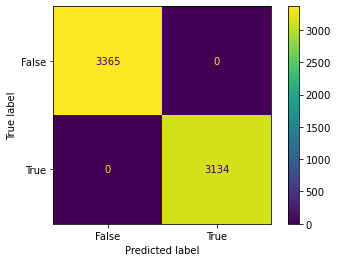

In [237]:
# Confusion matrix
conf_matrix_helper(model,X_train,y_train)

In [ ]:
# ROC AUC
for m in trmod2:
    RocCurveDisplay.from_predictions(y_train,m.predict(X_train))

### Evaluate model performance on test data

In [239]:
# Calculate baseline score
dummy = DummyClassifier()
dummy.fit(X_train,y_train)

baseline = accuracy_score(y_TEST,dummy.predict(X_TEST))

In [240]:
# Calculate model score
y_pred = model.predict(X_TEST)

test_score = accuracy_score(y_TEST,y_pred)
#test_score = precision_score(y_TEST,y_pred)
#test_score = recall_score(y_TEST,y_pred)
#test_score = f1_score(y_TEST,y_pred)
#test_score = model.score(X_TEST,y_TEST) # Scoring by accuracy


In [241]:
print(f"Accuracy on test data is: {test_score}")
print(f"Baseline to beat is: {baseline}")

Accuracy on test data is: 1.0
Baseline to beat is: 0.5187692307692308


### Refit best model on all data

In [ ]:
model.fit(X,y)